# Dog breed identification with Inception Resnet V2 Network

In this project we will try to create a neural network model that answers the qestion: "Can we identify the dog breed with deep learning?". In future, it can be used in image recognition software, or as a part of AI-powered identification system.  

Let's start the project with importing required libraries.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import os

# Import required Keras deep neural network libraries
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.python.keras.applications.xception import Xception
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Flatten, Dropout, BatchNormalization, Input
from tensorflow.python.keras import optimizers, regularizers
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import CSVLogger
from tensorflow.python.keras.utils import GeneratorEnqueuer

### Extract, transform, load (ETL).  
Let's prepare data for analysis.  
This project will use the Stanford Dogs dataset. It is the subset of ImageNet that contains 20,580 categorised images of 120 breeds of dogs from around the world [1]. The dataset is downloaded from Stanford Vision and Learning Lab [2]. Data is distributed in .tar format.

In [2]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2019-01-15 12:24:53--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  38.5MB/s    in 22s     

2019-01-15 12:25:15 (34.7 MB/s) - ‘images.tar’ saved [793579520/793579520]



After downloading the tarball, the GNU tar is used to unpack the archive.

In [3]:
!tar -xf images.tar

The Pandas DataFrame is created. The columns in this dataframe contain the original filename with file extension and dog breedm obtained from the name of each file's parent directory.

In [5]:
# Store the working directory path
path = '/viacheslav/working/Images/'

# Create a Pandas DataFrame consisting of filename and dog breed
data = pd.DataFrame(columns = ['id', 'breed'])
for folder in sorted(os.listdir(path)):
    for file in sorted(os.listdir(path + folder)):
        data = data.append({'id' : file, 'breed' : folder[10:]}, ignore_index=True)
        
data.head()

,id,breed
0,n02085620_10074.jpg,Chihuahua
1,n02085620_10131.jpg,Chihuahua
2,n02085620_10621.jpg,Chihuahua
3,n02085620_1073.jpg,Chihuahua
4,n02085620_10976.jpg,Chihuahua


We will need to move all the files into the single directory for compatibility with current version of Keras ImageDataGenerator [3]. In the future, method flow_from_dataframe() will be able to accept absolute paths from dataframe column provided the argument directory = None.  
We will move all files into a new folder named ImagesMV. All dataset file names are unique, renaming is not required.

In [6]:
# Create the new folder
!mkdir ImagesMV
# Move all files from all child directories into the new folder
!find "/viacheslav/working/Images/" -type f -print0 | xargs -0 mv -t /viacheslav/working/ImagesMV/
# Update the working directory path
path = '/viacheslav/working/ImagesMV/'

As a part of data quality assessment, let's visualise our data. Since it contains large number of categories, let's plot five of most and least common dog breeds in the dataset.

Text(0.5,1,'Bottom 5 dog breeds in dataset')

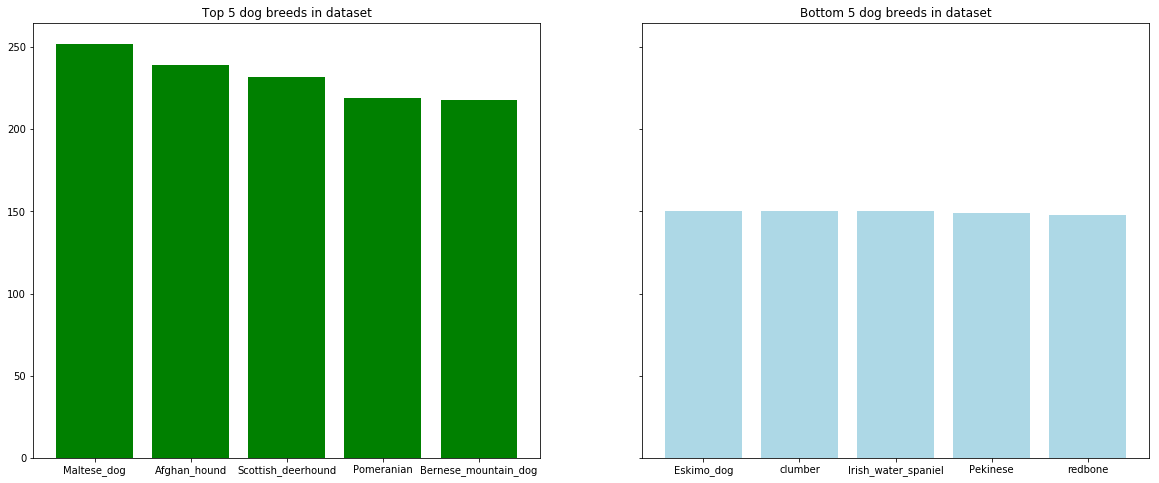

In [7]:
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(20,8))
axarr[0].bar(data['breed'].value_counts().head(5).index, data['breed'].value_counts().head(5), color = 'green')
axarr[0].set_title('Top 5 dog breeds in dataset')
axarr[1].bar(data['breed'].value_counts().tail(5).index, data['breed'].value_counts().tail(5), color = 'lightblue')
axarr[1].set_title('Bottom 5 dog breeds in dataset')

### Feature engineering.  
Our feature engineering part will consist of two steps.  
1. **Data augmentation.** We will generate batches of tensor image data with real-time data augmentation with help of Keras Image Preprocessing ImageDataGenerator class. Data augmentation will increase the number of training samples while adding robustness to the trained model. The data will be looped over in batches. We will shift images height and width by 10%, change the zoom level by 10%. We will flip images horizontally, but not vertically. Additionally, our data generator will resize our images to the size of 224 x 224 pixels and split 20% of input data into the validation dataset.  


2. **Categorical variables.** Since our categorical data (names of the breeds) is defined as variables with a finite set of label values, we will use one-hot encoding to convert our categories to one-hot vectors. It will be done automaticaly with the help of Keras ImageDataGenerator "class_mode" argument.

In [17]:
datagen = ImageDataGenerator(rescale=1./255.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             rotation_range=30,
                             vertical_flip=False,
                             horizontal_flip=True,
                             validation_split = 0.2)

train_generator = datagen.flow_from_dataframe(data,
                                              path,
                                              x_col = 'id',
                                              y_col = 'breed',
                                              has_ext = True,
                                              target_size = (224, 224),
                                              class_mode = 'categorical',
                                              batch_size = 21,
                                              shuffle = True,
                                              seed = 0,
                                              subset = 'training')

valid_generator = datagen.flow_from_dataframe(data,
                                              path,
                                              x_col = 'id',
                                              y_col = 'breed',
                                              has_ext = True,
                                              target_size = (224, 224),
                                              class_mode = 'categorical',
                                              batch_size = 21,
                                              shuffle = True,
                                              seed = 0,
                                              subset = 'validation')

Found 16464 images belonging to 120 classes.
Found 4116 images belonging to 120 classes.


### Model Training/Evaluation/Selection.
Now, we will compile, train and evaluate two convolutional neural network models.  
1. Convolutional neural network model based on Inception Resnet V2 Network.
2. Convolutional neural network model based on Xception Network.


Let's start with the first model based on Inception Resnet V2 Network [4], a convolutional neural network (CNN) that achieves great accuracy on the ILSVRC image classification benchmark. This neural network is an improved version of Inception V3 based on Microsoft ResNet research [5].

In [13]:
# Compile the first model based on Inception ResNet V2 Network
irnv2_base_model = InceptionResNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
irnv2_base_model.trainable = False

irnv2_image = Input((224, 224, 3))
irnv2_m = irnv2_base_model(irnv2_image)
irnv2_m = Dropout(0.5)(irnv2_m)
irnv2_m = Flatten()(irnv2_m)
irnv2_output = Dense(120, activation = 'softmax')(irnv2_m)

irnv2_model = Model(inputs = irnv2_image, outputs = irnv2_output)

irnv2_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

219062272/219055592 [==============================] - 2s 0us/step


We will train the first model and log the output.

In [14]:
csv_logger_inception_resnet_v2 = CSVLogger('log_inception.csv', append=True, separator=';')

irnv2_model.fit_generator(generator=train_generator,
                    steps_per_epoch=160,
                    validation_data=valid_generator,
                    validation_steps=100,
                    epochs=4,
                    callbacks=[csv_logger_inception_resnet_v2])

Epoch 1/4
100/100 [==============================] - 1970s 12s/step - loss: 3.2666 - acc: 0.3216 - val_loss: 1.7070 - val_acc: 0.6105
Epoch 2/4
100/100 [==============================] - 1800s 11s/step - loss: 2.2144 - acc: 0.5013 - val_loss: 1.5976 - val_acc: 0.6105
Epoch 3/4
100/100 [==============================] - 1800s 11s/step - loss: 2.1086 - acc: 0.5353 - val_loss: 1.5771 - val_acc: 0.6384
Epoch 4/4
100/100 [==============================] - 1800s 11s/step - loss: 1.8206 - acc: 0.5778 - val_loss: 1.7959 - val_acc: 0.5926


Let's store evaluation metrics in Pandas dataframe for future steps.

In [17]:
# Store evaluation metrics in Pandas dataframe 
log_inception_resnet_v2 = pd.read_csv('log_inception.csv', sep = ';', index_col = 'epoch')
log_inception_resnet_v2.head()

,acc,loss,val_acc,val_loss
epoch,,,,
0,0.321562,3.266563,0.610491,1.706985
1,0.501570,2.212228,0.610491,1.597641
2,0.535312,2.108615,0.638393,1.577071
3,0.577812,1.820616,0.592634,1.795909


Now, let's build another model based on Xception network, a convolutional neural network (CNN) that implements depthwise separable convolution approach.

In [7]:
# Compile the second model based on Xception Network
xc_base_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
xc_base_model.trainable = False

xc_image = Input((224, 224, 3))
xc_m = xc_base_model(xc_image)
xc_m = Dropout(0.5)(xc_m)
xc_m = Flatten()(xc_m)
xc_output = Dense(120, activation = 'softmax')(xc_m)

xc_model = Model(inputs = xc_image, outputs = xc_output)

xc_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

We will train the second model and log the output.

In [8]:
csv_logger_xception = CSVLogger('log_xception.csv', append=True, separator=';')

xc_model.fit_generator(generator=train_generator,
                    steps_per_epoch=160,
                    validation_data=valid_generator,
                    validation_steps=100,
                    epochs=4,
                    callbacks=[csv_logger_xception])

Epoch 1/4
100/100 [==============================] - 1880s 11s/step - loss: 3.1019 - acc: 0.3359 - val_loss: 1.7436 - val_acc: 0.5592
Epoch 2/4
100/100 [==============================] - 1780s 11s/step - loss: 2.0180 - acc: 0.5097 - val_loss: 1.6709 - val_acc: 0.5938
Epoch 3/4
100/100 [==============================] - 1780s 11s/step - loss: 1.7465 - acc: 0.5647 - val_loss: 1.4630 - val_acc: 0.6339
Epoch 4/4
100/100 [==============================] - 1740s 10s/step - loss: 1.4289 - acc: 0.6306 - val_loss: 1.5031 - val_acc: 0.6239


Let's store evaluation metrics in Pandas dataframe for future steps.

In [10]:
# Store evaluation metrics in Pandas dataframe 
log_xception = pd.read_csv('log_xception.csv', sep = ';', index_col = 'epoch')
log_xception.head()

,acc,loss,val_acc,val_loss
epoch,,,,
0,0.335938,3.101898,0.559152,1.743556
1,0.510364,2.016742,0.593750,1.670855
2,0.564688,1.746468,0.633929,1.462965
3,0.630625,1.428931,0.623884,1.503088


### Model performance assessment  
Now, let's visualise training loss, training accuracy and validation accuracy by epoch for both models.

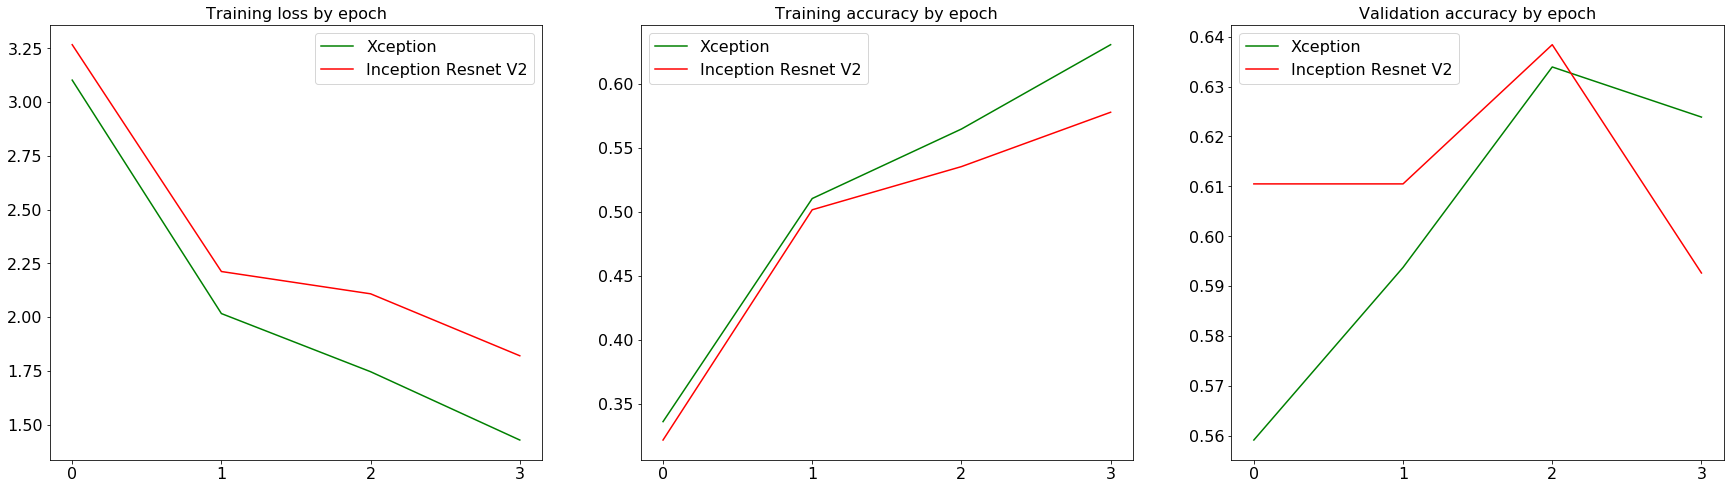

In [41]:
f, axarr = plt.subplots(1, 3, sharex = True, figsize = (30, 8))

for i in range(3):
    axarr[i].set_xticks(log_xception.index)
    axarr[i].tick_params(axis='both', which='major', labelsize=16)
    
green_line = mlines.Line2D([], [], color='green', label='Xception')
red_line = mlines.Line2D([], [], color='red', label='Inception Resnet V2')

# Plot training loss by epoch for both models
axarr[0].plot(log_xception.index, log_xception['loss'], color = 'green')
axarr[0].plot(log_inception_resnet_v2.index, log_inception_resnet_v2['loss'], color = 'red')
axarr[0].set_title('Training loss by epoch', fontsize = 16)
axarr[0].legend(handles=[green_line, red_line], fontsize = 16, loc='upper right')

# Plot training accuracy by epoch for both models
axarr[1].plot(log_xception.index, log_xception['acc'], color = 'green')
axarr[1].plot(log_inception_resnet_v2.index, log_inception_resnet_v2['acc'], color = 'red')
axarr[1].set_title('Training accuracy by epoch', fontsize = 16)
axarr[1].legend(handles=[green_line, red_line], fontsize = 16, loc='upper left')

# Plot validation accuracy by epoch for both models
axarr[2].plot(log_xception.index, log_xception['val_acc'], color = 'green')
axarr[2].plot(log_inception_resnet_v2.index, log_inception_resnet_v2['val_acc'], color = 'red')
axarr[2].set_title('Validation accuracy by epoch', fontsize = 16)
axarr[2].legend(handles=[green_line, red_line], fontsize = 16, loc='upper left')

From training accuracy and loss graphs we can see that models perform as expected, with better perfomance of Xception based model. Validation accuracy plot shows that accuracy of both models drops on 4th epoch, with Inception ResNet V2 based model outperforming the Xception based one. Based on this, I would recommend to choose Inception ResNet V2 based model while lowering the number of training epochs to 3 to prevent overfitting.  
Let's analyze our chosen model further.

In [84]:
# Create dictionary of classified breeds to lookup later
breeds_list = {value: key for key, value in valid_generator.class_indices.items()}
print(breeds_list)

{0: 'boston_bull', 1: 'dingo', 2: 'pekinese', 3: 'bluetick', 4: 'golden_retriever', 5: 'bedlington_terrier', 6: 'borzoi', 7: 'basenji', 8: 'scottish_deerhound', 9: 'shetland_sheepdog', 10: 'walker_hound', 11: 'maltese_dog', 12: 'norfolk_terrier', 13: 'african_hunting_dog', 14: 'wire-haired_fox_terrier', 15: 'redbone', 16: 'lakeland_terrier', 17: 'boxer', 18: 'doberman', 19: 'otterhound', 20: 'standard_schnauzer', 21: 'irish_water_spaniel', 22: 'black-and-tan_coonhound', 23: 'cairn', 24: 'affenpinscher', 25: 'labrador_retriever', 26: 'ibizan_hound', 27: 'english_setter', 28: 'weimaraner', 29: 'giant_schnauzer', 30: 'groenendael', 31: 'dhole', 32: 'toy_poodle', 33: 'border_terrier', 34: 'tibetan_terrier', 35: 'norwegian_elkhound', 36: 'shih-tzu', 37: 'irish_terrier', 38: 'kuvasz', 39: 'german_shepherd', 40: 'greater_swiss_mountain_dog', 41: 'basset', 42: 'australian_terrier', 43: 'schipperke', 44: 'rhodesian_ridgeback', 45: 'irish_setter', 46: 'appenzeller', 47: 'bloodhound', 48: 'samoye

Now, let's visualise most important errors. To achieve this we will predict labels for our validation set, and then compare real labels to our predictions. In this case, we will define prediction error as the difference between real and predicted label probabilities calculated by our model.

In [88]:
enqueuer = GeneratorEnqueuer(valid_generator)
enqueuer.start(max_queue_size=10, workers=4)

validation_df = pd.DataFrame(columns = ['Image', 'Label', 'Predicted label', 'Error'])

for i in range(0, 196):
    state, queue_data = enqueuer.queue.get()
    queue_images = queue_data[0]
    queue_labels = np.argmax(queue_data[1], axis = 1)
    queue_predict = irnv2_base_model.predict_on_batch(queue_images)
    queue_predicted_labels = np.argmax(queue_predict, axis = 1)
    queue_predicted_weights = np.max(queue_predict, axis = 1)
    for i in range(0, 21):
        if queue_labels[i] != queue_predicted_labels[i]:
            validation_df = validation_df.append({'Image' : queue_images[i],
                                                  'Label' : queue_labels[i],
                                                  'Predicted label' : queue_predicted_labels[i],
                                                  'Error' : queue_predicted_weights[i] - queue_predict[i][queue_labels[i]]
                                                 }, ignore_index=True)

enqueuer.stop()
validation_df.head(10)

,Image,Label,Predicted label,Error
0,"[[[0.43569162, 0.4513779, 0.486672], [0.444897...",103,36,0.993047
1,"[[[0.07450981, 0.050980397, 0.050980397], [0.0...",42,5,0.179280
2,"[[[0.25291663, 0.22938721, 0.17637523], [0.202...",49,97,0.195372
3,"[[[0.23199828, 0.41599917, 0.27482268], [0.231...",34,91,0.633639
4,"[[[0.28730154, 0.25985056, 0.228478], [0.29164...",54,113,0.072714
5,"[[[0.20239554, 0.17971393, 0.08788534], [0.140...",42,84,0.894804
6,"[[[0.20054688, 0.27560353, 0.30077356], [0.220...",52,8,0.257344
7,"[[[0.29088393, 0.26735452, 0.3079459], [0.2845...",75,5,0.321244
8,"[[[0.0627451, 0.12217728, 0.030155256], [0.071...",96,44,0.118515
9,"[[[0.75061375, 0.7560657, 0.75772345], [0.7502...",50,57,0.999182


In [89]:
# Sort
validation_df = validation_df.sort_values(by='Error', ascending=False)
validation_df.head(10)

,Image,Label,Predicted label,Error
242,"[[[0.3372549, 0.101669155, 0.020526184], [0.33...",63,37,0.999443
354,"[[[0.72437066, 0.64986086, 0.657704], [0.75144...",20,49,0.999433
281,"[[[0.46576947, 0.46547043, 0.5131274], [0.4659...",70,108,0.999431
9,"[[[0.75061375, 0.7560657, 0.75772345], [0.7502...",50,57,0.999182
307,"[[[0.4496968, 0.32028502, 0.24577521], [0.4479...",20,37,0.998946
360,"[[[0.59021676, 0.7142209, 1.0], [0.5809649, 0....",60,66,0.998591
348,"[[[0.4501102, 0.34030625, 0.2854043], [0.49081...",67,46,0.997764
81,"[[[0.18753609, 0.17969295, 0.18361452], [0.193...",18,88,0.997224
18,"[[[0.72695607, 0.67893285, 0.63701063], [0.733...",79,8,0.995310
401,"[[[0.7058824, 0.5568628, 0.5137255], [0.705882...",32,101,0.995300


Now, let's plot 9 largest errors with actual and predicted classes.

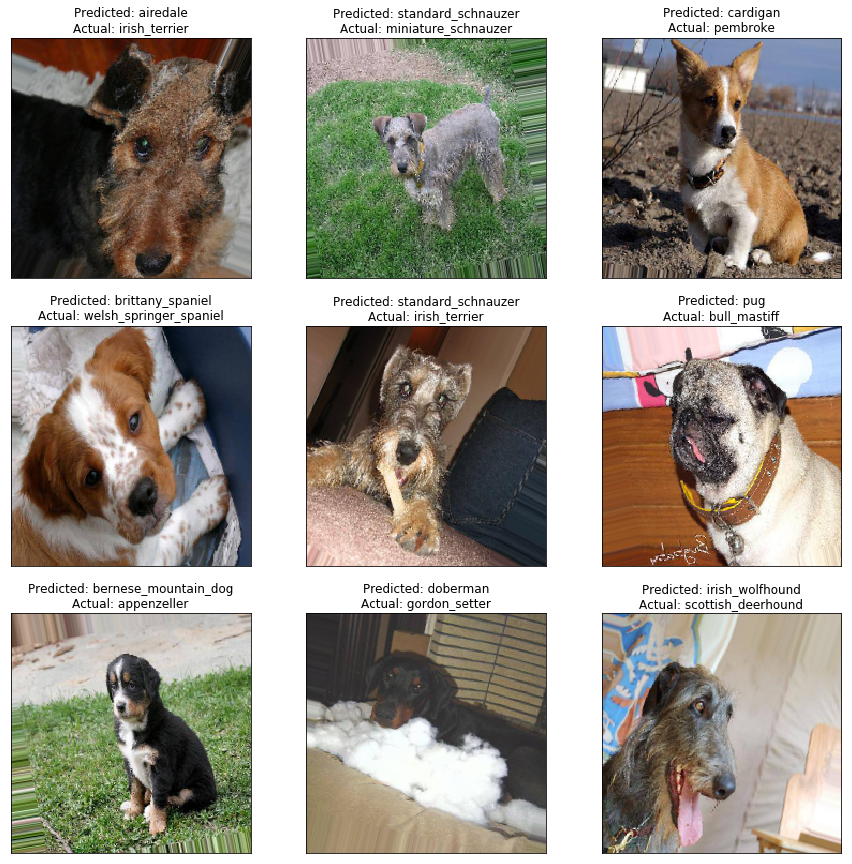

In [92]:
f, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,15))
k = 0
for i in range(3):
    for j in range(3):
        axarr[i, j].get_xaxis().set_visible(False)
        axarr[i, j].get_yaxis().set_visible(False)
        axarr[i, j].imshow(validation_df['Image'].values[k])
        axarr[i, j].set_title("Predicted: {}\nActual: {}".format(breeds_list[validation_df['Label'].values[k]],
                                                               breeds_list[validation_df['Predicted label'].values[k]]))
        k = k + 1

### Final Result  
In this project we successfully extracted, loaded, transformed our data, engineered new features and built two  neural network models. Based on analysis, we had choosen the Inception ResNet V2 based model. Our model can succesfully determine the dog breed with about 64% accuracy, which completes tasks and answers questions defined in the usecase.

### References
[1] Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.  
[2] Stanford Vision and Learning Lab [Online]. Available: http://vision.stanford.edu/aditya86/ImageNetDogs/. [Accessed January 15, 2019].  
[3] Keras Documentation, ImageDataGenerator methods [Online]. Available: https://keras.io/preprocessing/image/#flow_from_dataframe. [Accessed January 15, 2019].  
[4] Google AI Blog [Online]. Improving Inception and Image Classification in TensorFlow. Available: https://ai.googleblog.com/2016/08/improving-inception-and-image.html. [Accessed January 15, 2019].  
[5] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. Deep Residual Learning for Image Recognition. arXiv:1512.03385 [cs.CV]


<hr>
<p>This notebook and its source code were created by Viacheslav Barkov, 2019.</p>